In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature

In [2]:
import json
import sys
!{sys.executable} -m pip install PyAthena
import plotly
from pyathena import connect
import pandas as pd


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
from pyathena.async_cursor import AsyncCursor

q="""
select 
 longitude, 
 latitude,
 ( (sea_surface_temperature - 273.15) * (9.0/5.0) ) + 32.0 sst_f
from sci.abi_g16_star_l2p_v2_70
where 
 time_base = timestamp '2021-08-31 17:00:00.000'
--order by 
-- longitude
"""
cursor = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2', cursor_class=AsyncCursor).cursor(max_workers=2)
query_id, future = cursor.execute(q)
print (query_id, future)
#i=0
#for row in cursor:
#    if i==0:
#        print(row)
#    i+=1
#pd.options.display.float_format = '{:,.4f}'.format
#df = pd.read_sql(q, conn)
#df
result_set = future.result()
print(result_set.state)
print(result_set.state_change_reason)
print(result_set.completion_date_time)
print(result_set.submission_date_time)
print(result_set.data_scanned_in_bytes)
print(result_set.engine_execution_time_in_millis)
print(result_set.query_queue_time_in_millis)
print(result_set.total_execution_time_in_millis)
print(result_set.query_planning_time_in_millis)
print(result_set.service_processing_time_in_millis)
print(result_set.output_location)
print(result_set.description)

import boto3
s3_client = boto3.client('s3')

obj=result_set.output_location[result_set.output_location.rfind('/')+1:]
print(obj)

s3_client.download_file('esdis-ems-athena', obj, 'myOut.csv')

df=pd.read_csv('myOut.csv')  
df

e152a3c4-a392-40a8-8621-2d8c387c2e2c <Future at 0x7f525701bb00 state=running>
SUCCEEDED
None
2021-11-08 18:23:01.029000+00:00
2021-11-08 18:22:50.098000+00:00
35659416
10692
192
10931
579
47
s3://esdis-ems-athena/e152a3c4-a392-40a8-8621-2d8c387c2e2c.csv
[('longitude', 'float', None, None, 17, 0, 'UNKNOWN'), ('latitude', 'float', None, None, 17, 0, 'UNKNOWN'), ('sst_f', 'double', None, None, 17, 0, 'UNKNOWN')]
e152a3c4-a392-40a8-8621-2d8c387c2e2c.csv


,longitude,latitude,sst_f
0,-129.67575,-6.12430,78.872004
1,-129.67575,-4.75208,78.998018
2,-129.67574,-10.95118,78.440022
3,-129.67574,0.47741,73.652015
4,-129.67570,-5.00662,78.727974
...,...,...,...
4082799,-22.59604,-8.83702,78.656013
4082800,-22.59602,-16.59902,74.011982
4082801,-22.59598,-15.96442,74.930000
4082802,-22.59597,30.97490,77.990022


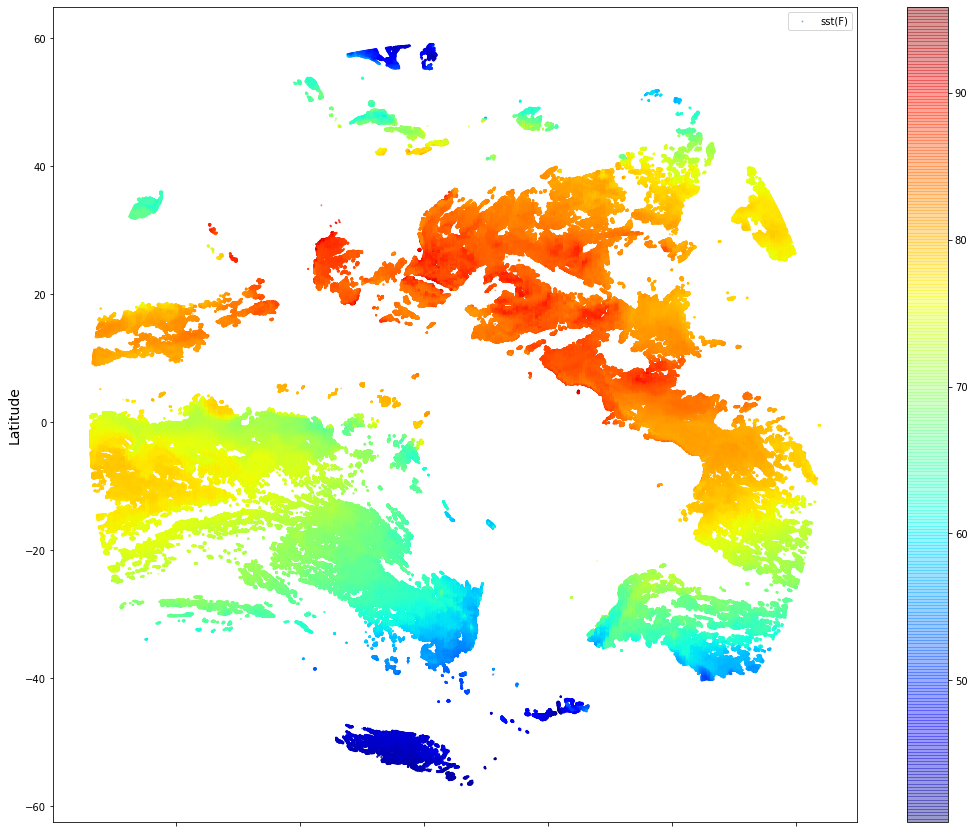

In [4]:
# Matplotlib

sst = df["sst_f"]
sst_c = []
for c in range(int(min(sst)), int(max(sst))):
    sst_c.append(c)


df.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude",
    s=df['sst_f']-df['sst_f']+1, 
    label="sst(F)", 
    c=df['sst_f'],
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(18,15),
)
plt.legend()
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
#plt.drawcoastlines()
#map.drawcountries()
#map.fillcontinents(color='coral')
#map.drawmapboundary()
plt.show()


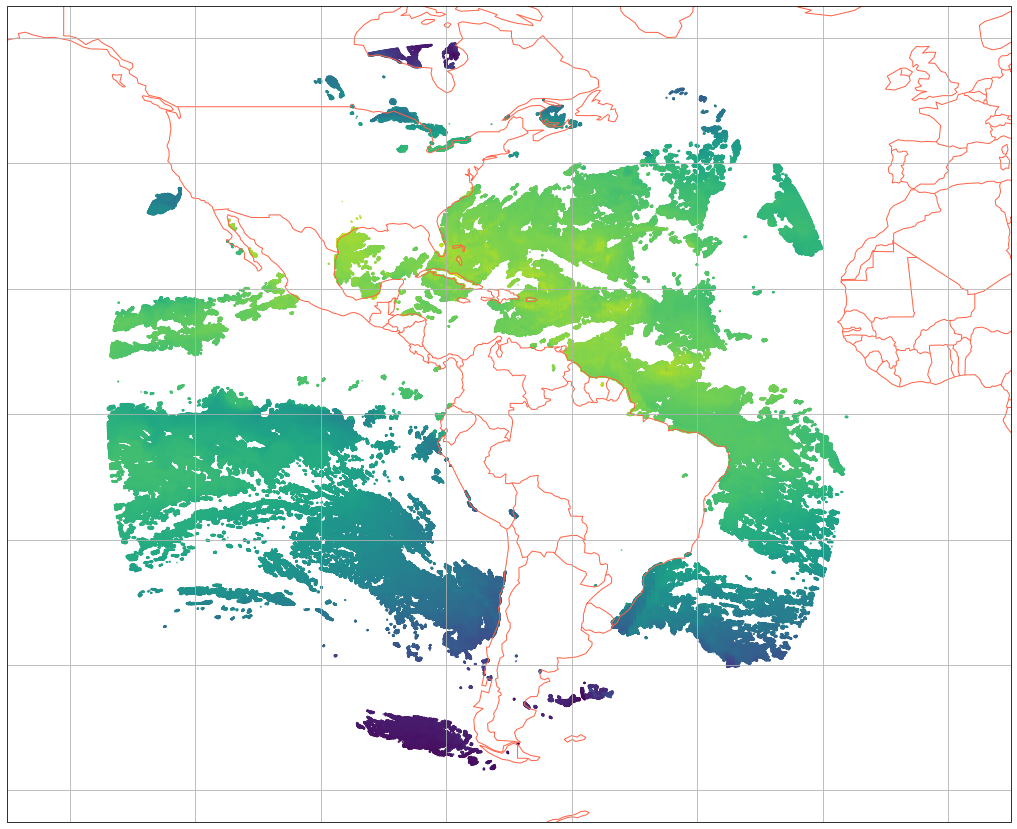

In [6]:
# cartopy
# Without colormap (default)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 


fig = plt.figure(figsize=(18,15))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

#ax.set_global()
ax.set_extent([-150, 10, -65, 65], crs=crs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

plt.scatter(x=df['longitude'], y=df['latitude'],
            c=df['sst_f'],
            s=1,
            alpha=0.5,
            transform=crs.PlateCarree()) ## Important

plt.show()

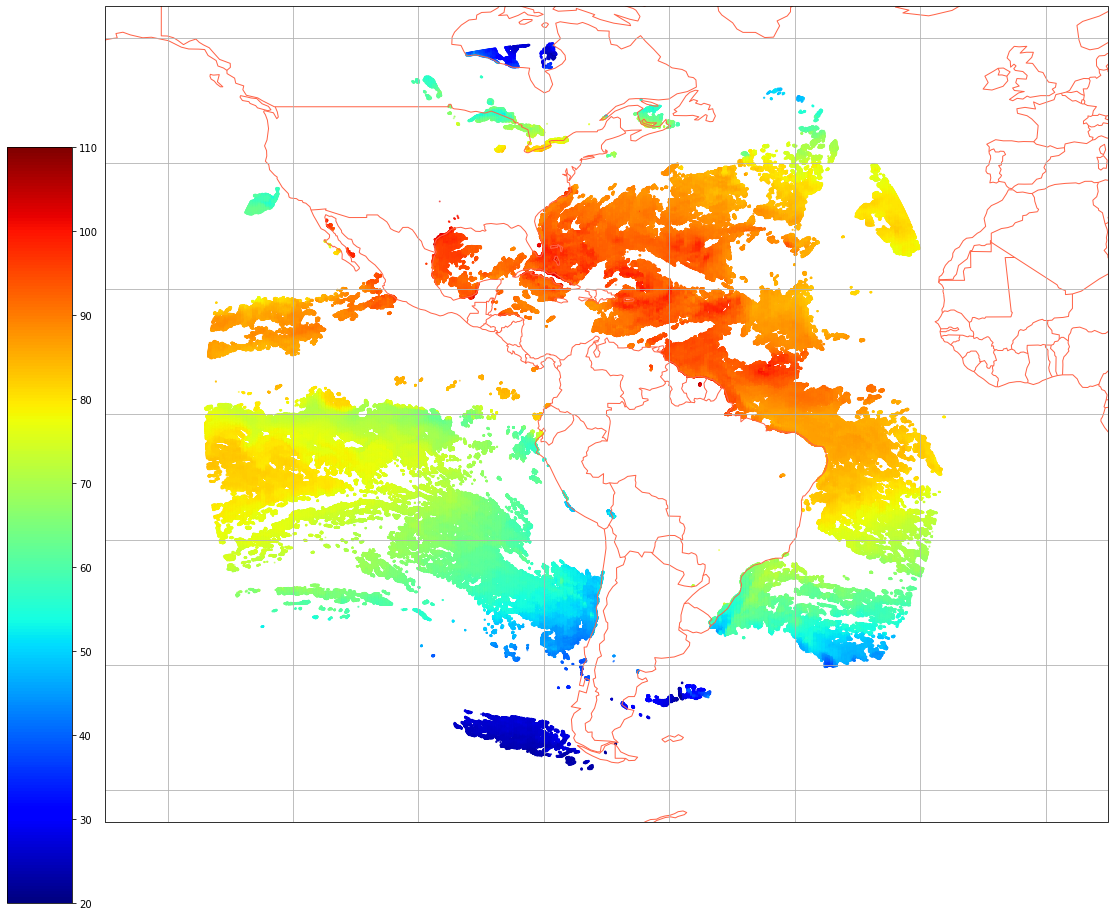

In [5]:
# Cartopy
# Color map


from matplotlib import colorbar, colors


fig = plt.figure(figsize=(18,15))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())



#ax.set_global()
ax.set_extent([-150, 10, -65, 65], crs=crs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

plt.scatter(x=df['longitude'], y=df['latitude'],
            c=df['sst_f'],
            cmap=plt.get_cmap("jet"),
            s=1,
            alpha=0.5,
            transform=crs.PlateCarree()) ## Important

ax = fig.add_axes([.05, .05, .05, .7]) # position of colorbar
cbar = colorbar.ColorbarBase(ax, cmap=plt.get_cmap('jet'),
  norm=colors.Normalize(vmin=20.0, vmax=110.0)) # set min, max of colorbar
#cbar.set_clim(-.5, .5) # set limits of color map

plt.show()


